# Greykite time series models

This model worked great for all searches, except Addiction. We have tuned it and fitted on data before COVID-19 and checked the difference in the forecast and Actual values for the beginning of the COVID-19 restrictions,
adapted from https://linkedin.github.io/greykite/docs/0.4.0/html/gallery/tutorials/0300_weekly_data.html

In [22]:
# Imports
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(42)

import plotly
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.utils.result_summary import summarize_grid_search_results
from collections import defaultdict

In [23]:
# Import data
combined_states = pd.read_csv(f'../data/combined_states.csv', parse_dates=['week'])
# Get the data before pandemic to see how the model performs before COVID-19 Restrictions
combined_states_before_covid = combined_states[combined_states['week'] < '04-2020']
combined_states_before_covid.tail()

,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
113,2020-03-01,63.4,64.4,23.2,38.2,36.4,0.0,0.0,0.0,0.0,0.0
114,2020-03-08,60.1,63.6,19.7,31.5,29.0,0.0,0.0,0.0,0.0,0.0
115,2020-03-15,65.4,60.4,14.6,24.9,28.2,0.1,0.0,0.1,0.1,0.0
116,2020-03-22,67.7,66.5,17.5,24.7,27.5,0.3,0.0,0.4,0.3,0.2
117,2020-03-29,67.3,67.9,17.6,20.1,30.4,0.7,0.1,0.7,0.6,0.4


In [24]:
# Get the data closer to the middle of the pandemic to see how the model predict after pandemic starts.
combined_states_begining_covid = combined_states[combined_states['week'] < '08-2020']
combined_states_begining_covid.tail()

,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
130,2020-06-28,51.8,67.7,21.3,31.8,33.9,0.2,0.5,0.7,0.7,0.5
131,2020-07-05,48.1,71.0,18.5,31.2,33.1,0.1,0.6,0.6,0.6,0.5
132,2020-07-12,52.1,65.7,17.3,31.4,35.0,0.1,0.6,0.7,0.7,0.5
133,2020-07-19,50.7,66.8,16.5,30.1,32.3,0.1,0.6,0.7,0.7,0.5
134,2020-07-26,49.3,69.0,19.0,34.0,32.4,0.1,0.6,0.7,0.7,0.5


In [37]:
def greykite_fit_explore(data, search, yearly_seasonality, quarterly_seasonality, monthly_seasonality, holiday_lookup_countries):
    '''
    Fit and Evaluate Greykite model with SILVERKITE
    Input:
    data - data frame, function will split it to train and test
    search - string, search term
    yearly_seasonality - int, up to 15
    quarterly_seasonality - int, up to 15 
    monthly_seasonality - int, up to 15
    holiday_lookup_countries - list of countries to look for the holidays
    
    Output:
    MSE
    Forecast vs Actual Plot
    
    Return: results
    '''
    search_str = search.title()
    if search == 'mental_health':
        search_str = 'Mental Health'
    
    # Split the data to train and test
    df_train, df_test = data[0:-10], data[-10:]
    # Make timeseries data
    ts = UnivariateTimeSeries()
    ts.load_data(df=df_train[['week', search]],
                 time_col='week',
                 value_col=search,
                 freq='W-SUN')
    # specify dataset information
    forecast_horizon = 13  # Forecast 13 weeks
    time_col = 'ts'  
    value_col = 'y'
    metadata = MetadataParam(time_col=time_col,  
                             value_col=value_col, 
                             freq="W-SUN")
    
    cv_min_train_periods = 52 * 2
     # Let CV use most recent splits for cross-validation.
    cv_use_most_recent_splits = True
     # Determine the maximum number of validations.
    cv_max_splits = 6
    evaluation_period = EvaluationPeriodParam(
         test_horizon=forecast_horizon,
         cv_horizon=forecast_horizon,
         periods_between_train_test=0,
         cv_min_train_periods=cv_min_train_periods,
         cv_expanding_window=True,
         cv_use_most_recent_splits=cv_use_most_recent_splits,
         cv_periods_between_splits=None,
         cv_periods_between_train_test=0,
         cv_max_splits=cv_max_splits,
     )
    

    # Specify the model parameters
    model_components = ModelComponentsParam(
         autoregression=None,
         seasonality={
             "yearly_seasonality": yearly_seasonality,
             "quarterly_seasonality": quarterly_seasonality,
             "monthly_seasonality": monthly_seasonality,
             "weekly_seasonality": 0,
             "daily_seasonality": 0
         },
         changepoints={
             'changepoints_dict': {
                 "method": "auto",
                 "resample_freq": "7D",
                 "regularization_strength": 0.5,
                 "potential_changepoint_distance": "14D",
                 "no_changepoint_distance_from_end": "60D",
                 "yearly_seasonality_order": 15,
                 "yearly_seasonality_change_freq": None,
             },
             "seasonality_changepoints_dict": None
         },
         events={
             "holiday_lookup_countries": holiday_lookup_countries
         },
         growth={
             "growth_term": None
         },
         custom={
             'feature_sets_enabled': False,
             'fit_algorithm_dict': dict(fit_algorithm='ridge'),
         }
     )

    forecast_config = ForecastConfig(
         model_template = 'SILVERKITE',
         metadata_param=metadata,
         forecast_horizon=forecast_horizon,
         coverage=0.95,
         evaluation_period_param=evaluation_period,
         model_components_param=model_components
     )

     # Run the forecast model
    forecaster = Forecaster()
    result = forecaster.run_forecast_config(
         df=ts.df,
         config=forecast_config
     )
    
    get_model_results_metrics(result)
    

    fig = result.backtest.plot().update_layout(yaxis_title=search_str)
    fig.write_image(f'../images/greykite_forecast_{search}.jpeg')
    fig.show('svg')
    #plotly.io.show(fig) # for interactive plots in jupyter notebook
    
    return result

In [38]:
def get_model_results_metrics(result):
    '''
    MSE from Greykite result
    Input - result from fitting greykite model
    
    Output - MSE 
    '''
    
    # Get the useful fields from the forecast result
    backtest = result.backtest
     
    # Check historical evaluation metrics (on the historical training/test set).
    backtest_eval = defaultdict(list)
    for metric, value in backtest.train_evaluation.items():
        if metric == 'MSE':
            backtest_eval[metric].append(value)
            backtest_eval[metric].append(backtest.test_evaluation[metric])
    metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
    print("=========================== Train/Test Evaluation =============================")
    print(metrics)

## Comparing forecasts before and during COVID (model fit before COVID started)

### Depression

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train       test
MSE  8.074369  24.398985


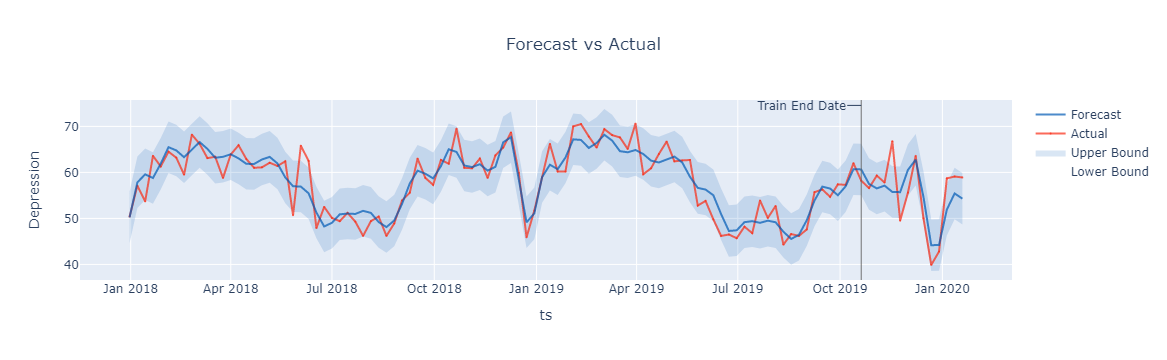

In [39]:
# Before COVID
depression_res_before = greykite_fit_explore(combined_states_before_covid, 'depression', yearly_seasonality=14, quarterly_seasonality = 0, monthly_seasonality = 0, holiday_lookup_countries=[])

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
         train       test
MSE  10.329079  37.463474


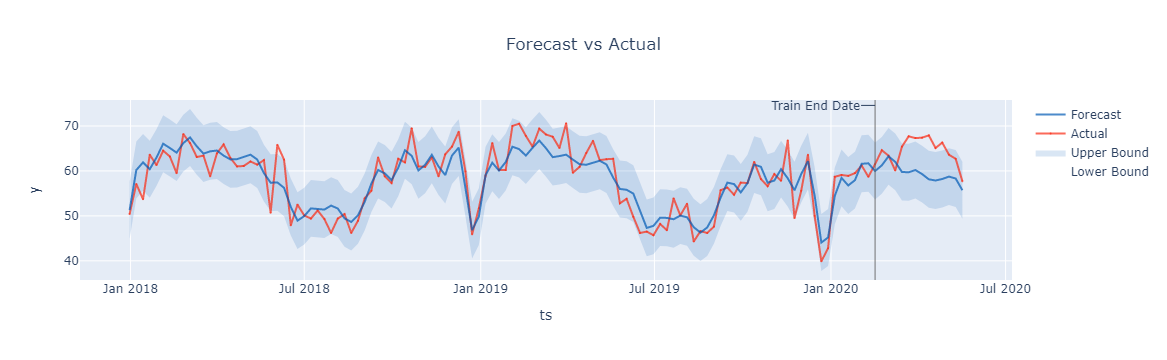

In [115]:
# During COVID
depression_res_covid = greykite_fit_explore(combined_states_begining_covid, 'depression', yearly_seasonality=14, quarterly_seasonality = 0, monthly_seasonality = 0, holiday_lookup_countries=[])

Depression pre COVID model was spot on, however, after COVID started there were more searches, and that model predicted

### Anxiety

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train       test
MSE  7.113283  22.357631


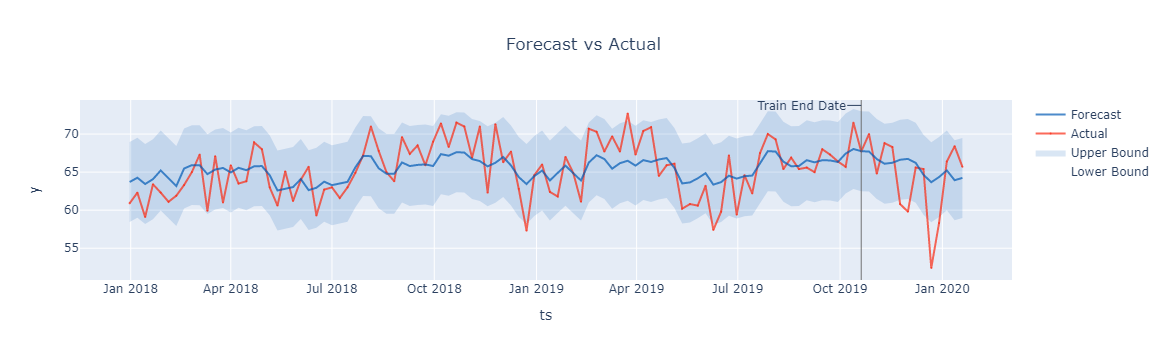

In [162]:
# Before COVID
anxiety_res_before = greykite_fit_explore(combined_states_before_covid, 'anxiety', yearly_seasonality=15, quarterly_seasonality = 15, monthly_seasonality = 0, holiday_lookup_countries=['US'])

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train      test
MSE  9.662404  9.341959


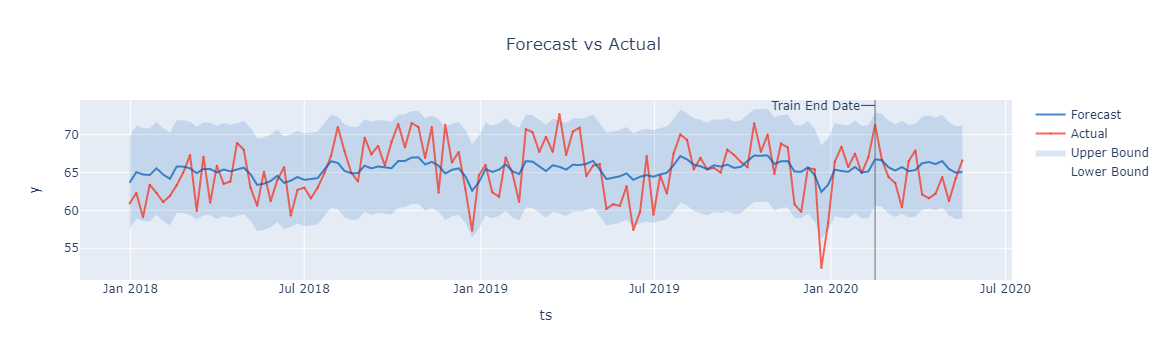

In [163]:
# During COVID
anxiety_res_covid = greykite_fit_explore(combined_states_begining_covid, 'anxiety', yearly_seasonality=15, quarterly_seasonality = 15, monthly_seasonality = 0, holiday_lookup_countries=['US'])

The addiction model was not so great, it did not have more errors in predicting after COVID started

### Addiction

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train      test
MSE  3.961186  8.215757


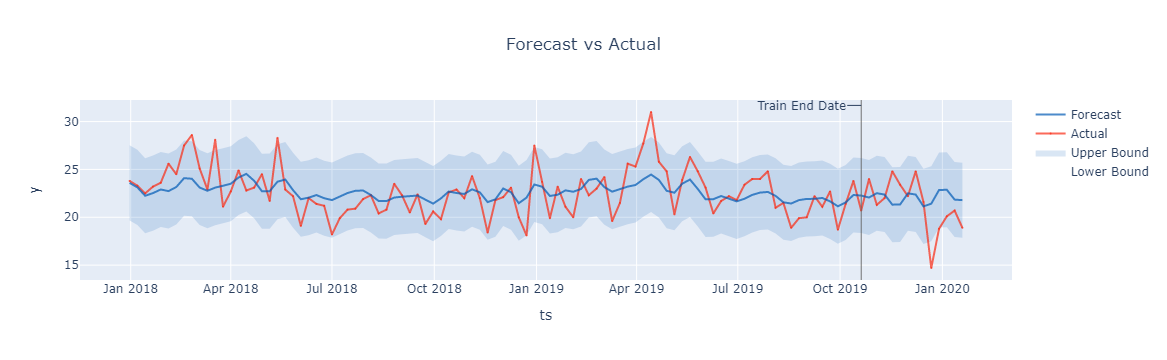

In [155]:
# Before COVID
addiction_res_before = greykite_fit_explore(combined_states_before_covid, 'addiction', yearly_seasonality=15, quarterly_seasonality = 0, monthly_seasonality = 0, holiday_lookup_countries=[])

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train       test
MSE  6.265363  12.818632


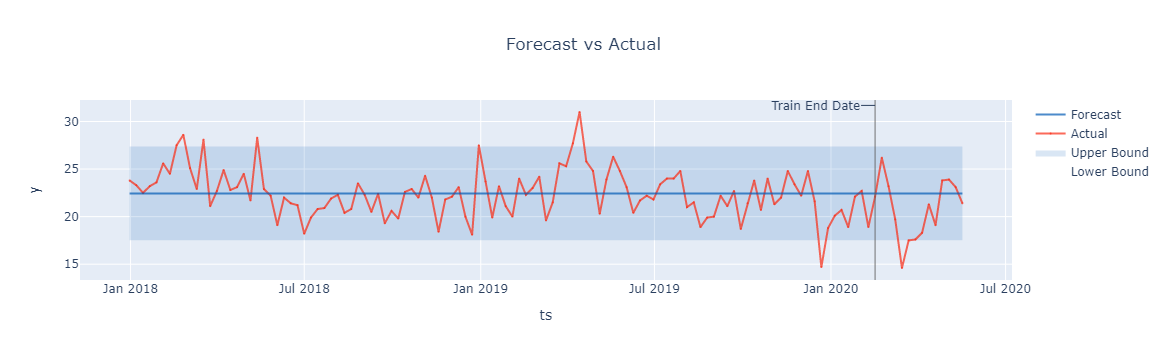

In [164]:
# During COVID
addiction_res_covid = greykite_fit_explore(combined_states_begining_covid, 'addiction', yearly_seasonality=15, quarterly_seasonality = 0, monthly_seasonality = 0, holiday_lookup_countries=[])

Addiction data was not predicted by the model, especially after COVID if failed to find a pattern.

### Counselling

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train       test
MSE  4.124944  29.786557


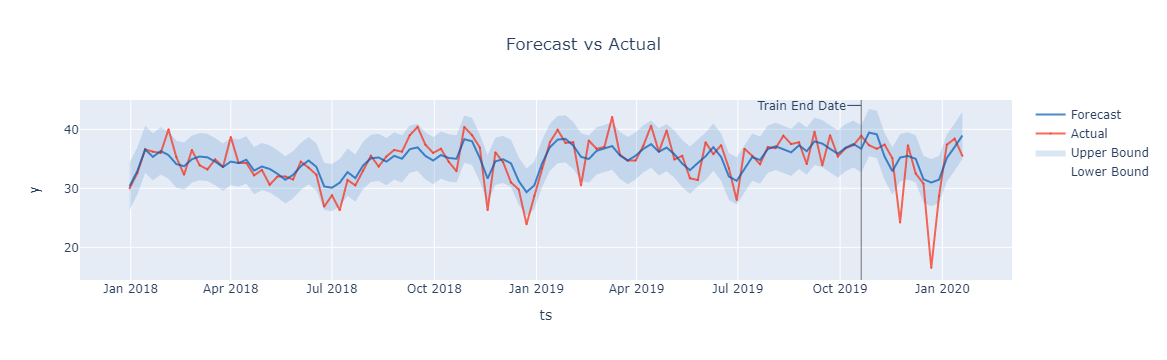

In [145]:
# Before COVID
counselling_res_before = greykite_fit_explore(combined_states_before_covid, 'counselling', yearly_seasonality=15, quarterly_seasonality = 15, monthly_seasonality = 0, holiday_lookup_countries=['US'])

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train       test
MSE  5.172629  95.890919


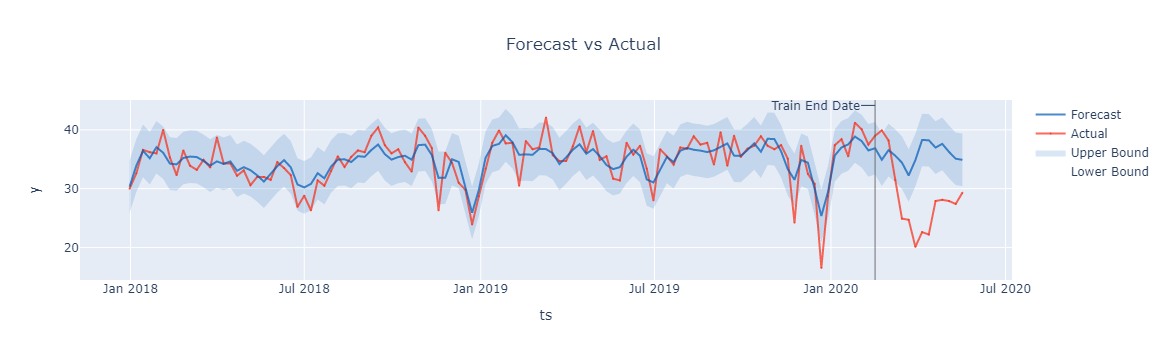

In [146]:
# During COVID
counselling_res_covid = greykite_fit_explore(combined_states_begining_covid, 'counselling', yearly_seasonality=15, quarterly_seasonality = 15, monthly_seasonality = 0, holiday_lookup_countries=['US'])

Counseling before COVID was predicted much better, than when COVID started. The model predicted much more Counseling searches than there were

### Mental Health

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train       test
MSE  4.722934  17.598015


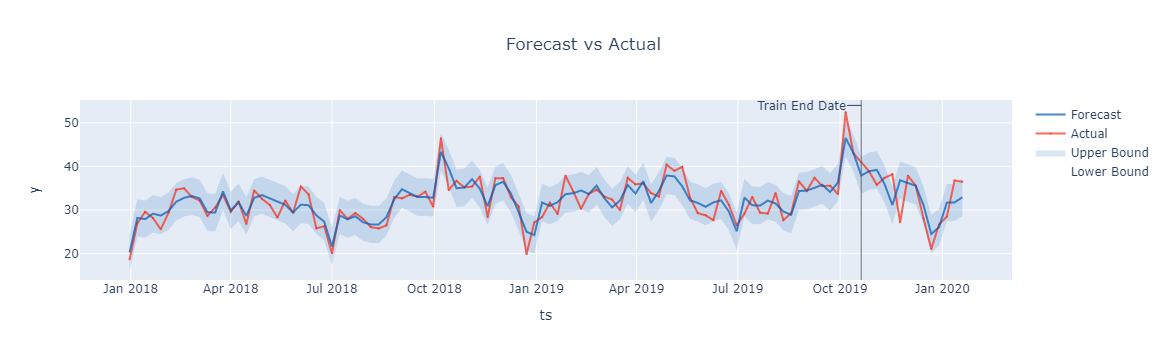

In [143]:
# Before COVID
mental_health_res_before = greykite_fit_explore(combined_states_before_covid, 'mental_health', yearly_seasonality=15, quarterly_seasonality = 15, monthly_seasonality = 0, holiday_lookup_countries=[])

Fitting 1 folds for each of 1 candidates, totalling 1 fits
=========================== Train/Test Evaluation =============================
        train      test
MSE  6.213209  20.59314


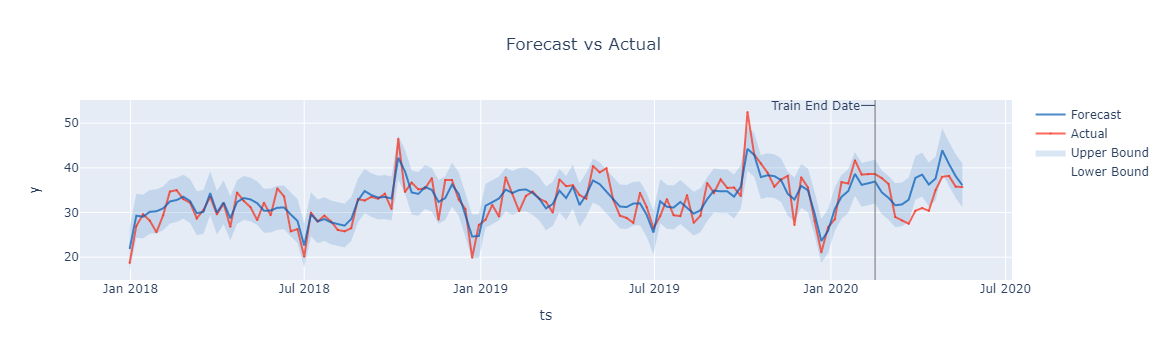

In [144]:
# During COVID
mental_health_res_covid = greykite_fit_explore(combined_states_begining_covid, 'mental_health', yearly_seasonality=15, quarterly_seasonality = 15, monthly_seasonality = 0, holiday_lookup_countries=[])

Mental Health was predicted very close to the actual before COVID, however, it predicted more Mental health searches after COVID started than there actually were.

---

# Conclusion

SARIMAX and Greykite a bit different predictions for the beginning of COVID-19. They agreed on Counseling searches been lower than expected.